## Transforming variables for linear regression and calculating coefficients



Assume that we have a point source that is emitting light with Power $P$. As the distance from the point source increases, this power is distributed over an increasingly large surface area. The surface area of a sphere (with radius $r$) is $4\pi r^2$. Therefore, the _intensity_ of light, which is the power per unit area, decreases with distance following an inverse square law:

$I = \frac{P}{4 \pi d^2}$

where $d$ is the distance from the point source (corresponding to the radius of a sphere with the point source at its centre).

From this, we can see that the intensity of light from from a point source is proportional to the inverse square of the distance from the source:

$I \propto \frac{1}{d^{2}}$

Below, we will load a dataset that contains measurements of intensity as a function of distance from a point source.

Run the cell below to load the data.

In [1]:
import pandas as pd

# load the intensity data
intensity_data = pd.read_csv("data/intensity.csv")

#### Exercise 1

**(a)** Print a quick summary of the `intensity_data` DataFrame so that you can see the column names, non-null values and data types in each column.

In [2]:
intensity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   distance               20 non-null     float64
 1   intensity              20 non-null     float64
 2   intensity_uncertainty  20 non-null     float64
dtypes: float64(3)
memory usage: 612.0 bytes


**(b)** In fact, this dataset contains distance values (measured in $m$), the intensity measured at that distance (measured in $W/m^2$) and its associated uncertainty (also in $W/m^2$). Make a quick plot to show the relationship between distance and intensity.

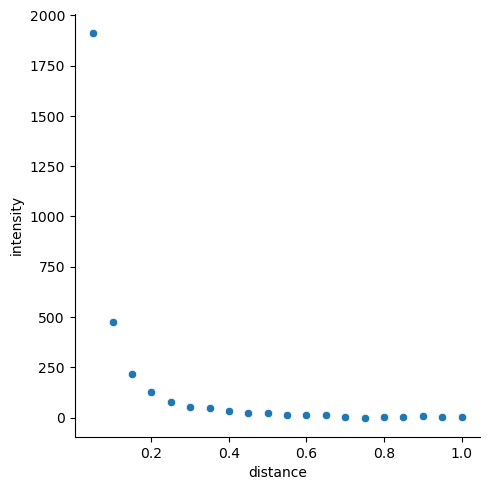

In [3]:
import seaborn as sns
sns.relplot(data=intensity_data,x="distance",y="intensity")

#### Exercise 2

We know that the intensity of a point source is proportional to the inverse square of the distance from it. With this knowledge of the expected relationship, we can deduce that if we wanted to fit a linear model to this distribution to predict intensity at a given distance, we should plot intensity as a function of $\frac{1}{d^2}$. In doing this we would have the following $x$ and $y$ values for a linear regression:
- $x = \frac{1}{d^2}$
- $y = I$

This would enable a linear regression of the form $y = mx + c$, where $m$ is the gradient (or _coefficient_) and $c$ is the _intercept_, as usual.

Add a new column to the data DataFrame called `inv_distance_sq`, containing the above calculated quantity. Once done, make a plot to show intensity as a function of $\frac{1}{d^2}$ to confirm that you see the linear relationship that you expect.

In [4]:
intensity_data["inv_distance_sq"] = 1 / intensity_data["distance"] ** 2

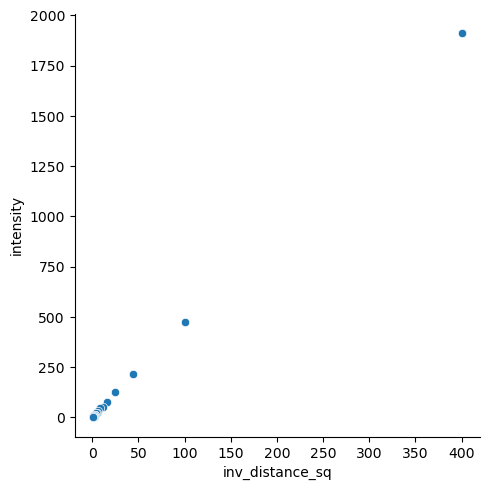

In [5]:
sns.relplot(data=intensity_data,x="inv_distance_sq",y="intensity")

#### Exercise 3

Use the newly created column in your DataFrame to predict the intensity in your dataset. 

Remember to:
- Separate your inputs into testing and training sets.
- Set _hyperparameters_ - here we should allow our model to fit the intercept, since there may be a systematic effect associated with the intensity measurements that result in the intercept being non-zero.
- Print out the $R^2$ score and root mean squared error.

In [6]:
from sklearn.model_selection import train_test_split
inv_square = intensity_data[["inv_distance_sq"]]
intensity = intensity_data["intensity"]
(train_invsquare, test_invsquare), (train_intensity, test_intensity) = train_test_split(inv_square, test_size=0.3, random_state=42), train_test_split(intensity, test_size=0.3,random_state=42)


from sklearn import linear_model
model = linear_model.LinearRegression(fit_intercept=True)

model.fit(train_invsquare, train_intensity)
predicted_intensity = model.predict(test_invsquare)

from sklearn.metrics import r2_score, mean_squared_error
print(f"r2 score: {r2_score(predicted_intensity, test_intensity)}")
print(f"root mean squared error: {mean_squared_error(predicted_intensity, test_intensity, squared=False)}")

r2 score: 0.9977025748320729
root mean squared error: 34.58047866511168


#### Exercise 4

Using your linear model, calculate the power of this point source. You may find it helpful to refer back to the equation relating Intensity, Power and Distance: 

$I = \frac{P}{4 \pi d^2}$

In [7]:
import numpy as np
gradient = model.coef_
power = 4 * np.pi * gradient[0]
print(f"Power of the point source: {power}")

Power of the point source: 62.74028554455694


#### Exercise 5

In fact this experiment was carried out using a $60~W$ bulb, so we expect power, $P$, to be close to $60$. How close is your estimate using the results of your linear model? We're going to try making use of the _uncertainty_ information contained in our DataFrame to see if we can get any closer to our known power of $60~W$. 

**(a)** Create a new linear regression model, but this time include _sample_weights_ in your training. To do this you will need to:
- Create a new weights series calculated as: $\frac{1}{\sigma^2}$, where $\sigma$ corresponds to the intensity uncertainty.
- Include the weights series as input to `train_test_split()`.
- Use the train set weights when training the linear regression model.

Is the $R^2$ score much improved?

In [8]:
intensity_data["weight"] = np.ones(intensity_data.shape[0])
intensity_data["weight"] *= 1 / intensity_data["intensity_uncertainty"] ** 2
weight = intensity_data["weight"]

(train_invsquare, test_invsquare), (train_intensity, test_intensity), (train_weight, test_weight) = train_test_split(inv_square, test_size=0.3, random_state=42), train_test_split(intensity, test_size=0.3,random_state=42), train_test_split(weight, test_size=0.3, random_state=42)

weighted_model = linear_model.LinearRegression(fit_intercept=True)

weighted_model.fit(train_invsquare, train_intensity, sample_weight=train_weight)
predicted_intensity = weighted_model.predict(test_invsquare)

from sklearn.metrics import r2_score, mean_squared_error
print(f"weighted r2 score: {r2_score(predicted_intensity, test_intensity)}")
print(f"weighted root mean squared error: {mean_squared_error(predicted_intensity, test_intensity, squared=False)}")

weighted r2 score: 0.9999190104539069
weighted root mean squared error: 6.265082525653148


**(b)** Recalculate the power using the results of this new regression model. Are you any closer to the true value of $P$?

In [9]:
gradient = weighted_model.coef_
power = 4 * np.pi * gradient[0]
print(f"Power of the weighted model is: {power}")

Power of the weighted model is: 60.54084678843784
